<a href="https://colab.research.google.com/github/JasonLimJS/EURUSD_Forecast/blob/master/3_Back_Testing_Trading_Strategy_with_The_Trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction:**

This document details all the steps involved in the daily backtesting of my trading strategies with the neural network ensemble trained.

**Background:**

It has been observed that EUR/USD pair is being traded in a highly volatile market and always reverting to a mean value that varies stochastically. After some experimentations, it has been found that the forecasted rates predicted by the trained neural network ensemble consists of the stochastically-varied value that this pair is reverting to, dependent on the EUR 3-Month LIBOR and USD 3-Month LIBOR. 

Hence, a mean-reverting strategy could be constructed.

**Trading Strategy Overview:**

1. Neural network ensemble is used to determine the mean EUR/USD rate with EUR 3-Month LIBOR   
    and USD 3- Month LIBOR as input data.
    
2. The difference of bid rate and mean rate is computed across time to determine sell trigger while 
     the difference between ask rate and mean rate is computed to determine buy trigger.
     
3. Buy trigger and sell trigger of various thresholds are experimented in order to determine the  
    optimal threshold that produces greatest returns.


STEP 1: Import relevant libraries, input data and trained models

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import norm
from tensorflow.math import erf
import warnings
import matplotlib.pyplot as plt

drive.mount('drive')

raw_data= pd.read_csv('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/input_data.csv')
model_1= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model1.h5')
model_2= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model2.h5')
model_3= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model3.h5')
model_4= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model4.h5')
model_5= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model5.h5')
model_6= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model6.h5')
model_7= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model7.h5')
model_8= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model8.h5')
model_9= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model9.h5')
model_10= load_model('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/EURUSD_model10.h5')

STEP 2: Pre-process data for deploymnet.

In [0]:
#Define parameters:

scaled_params= pd.read_csv('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/scaled_params.csv')
y_train_mean= scaled_params['y_train_mean'].values
y_train_sd= scaled_params['y_train_sd'].values
X_train_min_c1= scaled_params['X_train_min_c1'].values
X_train_max_c1= scaled_params['X_train_max_c1'].values
X_train_min_c2= scaled_params['X_train_min_c2'].values
X_train_max_c2= scaled_params['X_train_max_c2'].values
y_train_min= scaled_params['y_train_min'].values
y_train_max= scaled_params['y_train_max'].values

raw_data['EURUSD_lead']= raw_data['EURUSD'].shift(-1)
raw_data['EURUSD_return']= (raw_data.EURUSD_lead/raw_data.EURUSD-1)*100
raw_data.dropna(inplace=True)
raw_data.drop(['EURUSD','EURUSD_lead','vix','bond_spread','ice_swap_2y','ice_swap_3y','ice_swap_5y','ice_swap_7y','snp500','usd_libor_1m','eur_libor_1m'],axis=1,inplace=True)

target_pre= raw_data['EURUSD_return'].values
predictors_pre= raw_data.drop(['EURUSD_return'],axis=1).values

target_pre1= (target_pre- y_train_mean)/y_train_sd
target= (target_pre1- y_train_min)/(y_train_max-y_train_min)
target= target.reshape(-1,1)

predictors_c1= (predictors_pre[:,0] - X_train_min_c1)/(X_train_max_c1 -X_train_min_c1)
predictors_c2= (predictors_pre[:,1] - X_train_min_c2)/(X_train_max_c2 -X_train_min_c2)

predictors= np.column_stack([predictors_c1,predictors_c2])


STEP 3: Deploying ensembled ANN model to predict EURUSD of T+1.

RMSE of the model forecast is: 41.70643103552176 pips


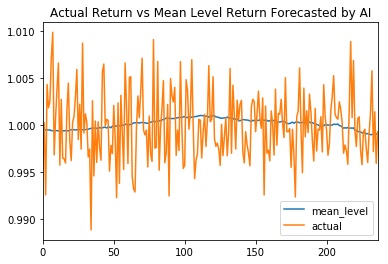

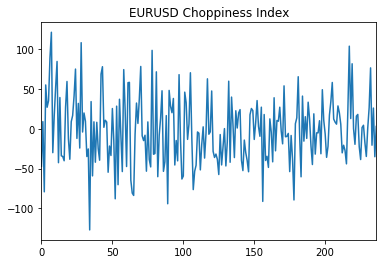

In [3]:
y_pred_1= model_1.predict(predictors)
y_pred_2= model_2.predict(predictors)
y_pred_3= model_3.predict(predictors)
y_pred_4= model_4.predict(predictors)
y_pred_5= model_5.predict(predictors)
y_pred_6= model_6.predict(predictors)
y_pred_7= model_7.predict(predictors)
y_pred_8= model_8.predict(predictors)
y_pred_9= model_9.predict(predictors)
y_pred_10= model_10.predict(predictors)

y_pred= (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5 + y_pred_6 + y_pred_7 + y_pred_8 + y_pred_9 + y_pred_10)/10

y_pred_deminmax= y_pred*(y_train_max-y_train_min)+y_train_min
y_pred_denorm= y_pred_deminmax*y_train_sd + y_train_mean
y_pred= 1+ y_pred_denorm/100

ori_data= pd.read_csv('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/input_data.csv')

eurusd_forecast= y_pred*ori_data.EURUSD.values[:-1].reshape(-1,1)
RMSE_forecast= MSE(ori_data.EURUSD.values[1:],eurusd_forecast)**0.5

print('RMSE of the model forecast is: ' + str(RMSE_forecast*10000) + ' pips')

return_forecast= eurusd_forecast/ori_data.EURUSD.values[:-1].reshape(-1,1)
retrun_actual= ori_data.EURUSD.values[1:].reshape(-1,1)/ori_data.EURUSD.values[:-1].reshape(-1,1)
return_forecast_ls= return_forecast.reshape(-1).tolist()
return_actual_ls= retrun_actual.reshape(-1).tolist()

valuation_matrix= pd.DataFrame({'mean_level':return_forecast_ls,'actual':return_actual_ls})
valuation_matrix.plot()
plt.title('Actual Return vs Mean Level Return Forecasted by AI')
plt.show()

mean_eurusd= eurusd_forecast.reshape(-1).tolist()
actual_eurusd= ori_data.EURUSD.values[1:].tolist()
eurusd_compare= pd.DataFrame({'mean':mean_eurusd,'eurusd':actual_eurusd})
eurusd_compare['strength']= (-eurusd_compare['mean'] + eurusd_compare['eurusd'])*10000
eurusd_compare['strength'].plot()
plt.title('EURUSD Choppiness Index')
plt.show()

STEP 4: Determine sell trigger and take profit (sell_buy) trigger should the sell trigger is activated.

In [8]:
bid_ask_spread= 0.0001

eurusd_compare['ask']= eurusd_compare['eurusd'] + bid_ask_spread
eurusd_compare['bid']= eurusd_compare['eurusd'] - bid_ask_spread

sell_trigger= np.linspace(10,100,20)
buy_trigger= np.linspace(-100,0,20)

b_ls= []
s_ls= []
total_profit_ls=[]
  
for s_index in range(len(sell_trigger)):
  for b_index in range(len(buy_trigger)):
    
    sell= 0
    total_profit=0
    
    for i in range(len(eurusd_compare)):
      
      b= buy_trigger[b_index]
      s= sell_trigger[s_index]
      
      if sell==0 and eurusd_compare['strength'].iloc[i] >= s: 
         sell = 1
         sell_price= eurusd_compare['bid'].iloc[i]
        
      if sell== 1 and  eurusd_compare['strength'].iloc[i] <= b:
         buy_price= eurusd_compare['ask'].iloc[i]
         profit= sell_price - buy_price
         
         if profit >0:
            total_profit += profit
            sell=0
  
    b_ls.append(b)
    s_ls.append(s)
    total_profit_ls.append(total_profit)
   
sell_price_df= pd.DataFrame({'sell_buy_trigger':b_ls,'sell_trigger':s_ls,'total_profit':total_profit_ls})
sell_price_df.sort_values(by='total_profit',ascending=False,inplace=True)
sell_price_df.head(5)

,sell_buy_trigger,sell_trigger,total_profit
37,-10.526316,14.736842,0.0683
36,-15.789474,14.736842,0.0676
211,-42.105263,57.368421,0.0650
31,-42.105263,14.736842,0.0641
191,-42.105263,52.631579,0.0631


STEP 5:  Determine buy trigger and take profit (buy_sell) trigger should the buy trigger is activated.

In [9]:
b_ls= []
s_ls= []
total_profit_ls=[]
  
for b_index in range(len(buy_trigger)):
  for s_index in range(len(sell_trigger)):
    
    buy= 0
    total_profit=0
    
    for i in range(len(eurusd_compare)):
      
      b= buy_trigger[b_index]
      s= sell_trigger[s_index]
      
      if buy==0 and eurusd_compare['strength'].iloc[i] <=b: 
         buy = 1
         buy_price= eurusd_compare['ask'].iloc[i]
        
      if buy== 1 and  eurusd_compare['strength'].iloc[i] >=s:
         sell_price= eurusd_compare['bid'].iloc[i]
         profit= sell_price - buy_price
         
         if profit >0:
            total_profit += profit
            buy=0
  
    b_ls.append(b)
    s_ls.append(s)
    total_profit_ls.append(total_profit)
   
buy_price_df= pd.DataFrame({'buy_trigger':b_ls,'buy_sell_trigger':s_ls,'total_profit':total_profit_ls})
buy_price_df.sort_values(by='total_profit',ascending=False,inplace=True)
buy_price_df.head(5)

,buy_trigger,buy_sell_trigger,total_profit
161,-57.894737,14.736842,0.0467
163,-57.894737,24.210526,0.0463
162,-57.894737,19.473684,0.0463
165,-57.894737,33.684211,0.0406
164,-57.894737,28.947368,0.0406


STEP 6: Backtest Result.

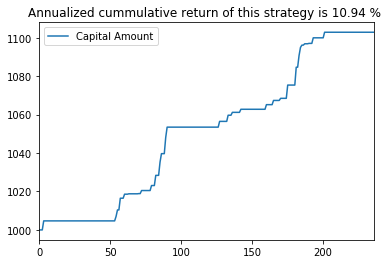

In [6]:
sell_trigger= sell_price_df['sell_trigger'].iloc[0]
sell_buy_trigger= sell_price_df['buy_trigger'].iloc[0]

buy_trigger= buy_price_df['buy_trigger'].iloc[0]
buy_sell_trigger= buy_price_df['sell_trigger'].iloc[0]

eurusd_compare

buy=0
sell=0
total_profit=0
total_profit_ls=[]


for i in range(len(eurusd_compare)):
#for i in [0]:
  
  
  #Closing sell trigger:
  if sell==1 and eurusd_compare.strength.iloc[i] <= sell_buy_trigger:
    buy_price= eurusd_compare.ask.iloc[i]

    if sell_price > buy_price:
      profit= sell_price- buy_price
      total_profit = total_profit + profit
      sell=0

  #Closing buy trigger:
  if buy==1 and eurusd_compare.strength.iloc[i] >= buy_sell_trigger:
    sell_price= eurusd_compare.bid.iloc[i]

    if sell_price > buy_price:
      profit= sell_price- buy_price
      total_profit = total_profit + profit
      buy=0  


  #Condition to activate sell trigger:
  if buy==0 and sell==0 and eurusd_compare.strength.iloc[i] >= sell_trigger:
    sell= 1
    sell_price= eurusd_compare.bid.iloc[i]

  #Condition to activate buy trigger:
  if sell== 0 and buy==0 and eurusd_compare.strength.iloc[i] <= buy_trigger:
    buy= 1
    buy_price= eurusd_compare.ask.iloc[i]


  total_profit_ls.append(total_profit)




init_capital= 1000
cumm_return= [(1+x)* init_capital for x in total_profit_ls]
cumm_return_pct= (cumm_return[-1]/init_capital-1)*100
cumm_return_ann= cumm_return_pct*252/len(total_profit_ls)

pd.DataFrame({'Capital Amount': cumm_return}).plot()
plt.title('Annualized cummulative return of this strategy is ' + str(round(cumm_return_ann,2)) + ' % ')
plt.show()

STEP 7: Saving backtest result and all relevant parameters.

In [0]:
sell_trigger= sell_price_df['sell_trigger'].iloc[0]
sell_buy_trigger= sell_price_df['buy_trigger'].iloc[0]

buy_trigger= buy_price_df['buy_trigger'].iloc[0]
buy_sell_trigger= buy_price_df['sell_trigger'].iloc[0]

trigger_data= pd.DataFrame({'buy': [buy_trigger], 'close_buy': [buy_sell_trigger],'sell':[sell_trigger],'close_sell':[sell_buy_trigger]})
trigger_data.to_csv('trigger_data.csv',index=False)

!cp trigger_data.csv drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/